In [1]:
from astropy import units as u
import astropy.io.fits as fits
from astropy.table import vstack
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy.stats import sigma_clip
from matplotlib import pyplot

import numpy
import pandas
import seaborn

import os
import urllib

import swasputils

In [2]:
SWASP_ID = '1SWASP J013908.39-472450.8'
FOLDING_PERIOD = 0
SIGMA_CLIP = 4
START_TIME = 269577963.24
END_TIME = 269577963.24 + 90 * 24 * 60 * 60

In [3]:
vespa = pandas.read_csv(os.path.join(swasputils.DATA_LOCATION, 'vespa-export.csv'))

In [4]:
fits_urls = vespa[vespa['SuperWASP ID'] == SWASP_ID.replace(' ', '')]['FITS URL'].unique()

In [5]:
if len(fits_urls) == 0:
    fits_url = 'http://wasp.warwick.ac.uk/lcextract?{}'.format(
        urllib.parse.urlencode(
            {'objid': SWASP_ID.replace('1SWASPJ', '1SWASP J')},
            quote_via=urllib.parse.quote,
        )
    )
else:
    fits_url = fits_urls[0]
fits_url

'http://wasp.warwick.ac.uk/lcextract?objid=1SWASP%20J013908.39-472450.8'

In [6]:
fits_file = fits.open(fits_url)
hjd_col = fits.Column(name='HJD', format='D', array=fits_file[1].data['TMID'] / 86400 + 2453005.5)
lc_data = fits.BinTableHDU.from_columns(fits_file[1].data.columns + fits.ColDefs([hjd_col]))
timeseries = TimeSeries.read(lc_data, time_column='HJD', time_format='jd')

In [7]:
if START_TIME > 0:
    START_TIME = Time(START_TIME / 86400 + 2453005.5, format='jd')
    timeseries = timeseries[timeseries['time'] > START_TIME]
if END_TIME > 0:
    END_TIME = Time(END_TIME / 86400 + 2453005.5, format='jd')
    timeseries = timeseries[timeseries['time'] < END_TIME]

In [8]:
if FOLDING_PERIOD > 0:
    timeseries = timeseries.fold(period=FOLDING_PERIOD * u.second)
    epoch_length = timeseries['time'].max() - timeseries['time'].min()
    ts_out = [timeseries]
    ts_new = timeseries.copy()
    ts_new['time'] = ts_new['time'] + epoch_length
    ts_out.append(ts_new)
    timeseries = vstack(ts_out)

In [9]:
if SIGMA_CLIP > 0:
    ts_flux = sigma_clip(timeseries['TAMFLUX2'], sigma=SIGMA_CLIP)
else:
    ts_flux = timeseries['TAMFLUX2']

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


(243.38438415527344, 498.50831604003906)

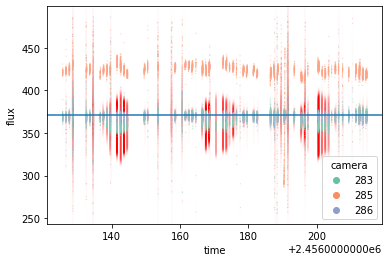

In [10]:
ts_data = {
    'time': timeseries.time.jd,
    'flux': ts_flux,
    'err': timeseries['TAMFLUX2_ERR'],
    'camera': timeseries['CAMERA_ID'],
}
fig = pyplot.figure()
seaborn.scatterplot(
    data=ts_data,
    x='time',
    y='flux',
    alpha=0.5,
    s=1,
    palette='Set2',
    hue='camera',
)
lims = pyplot.ylim()
pyplot.axhline(numpy.median(ts_flux))

pyplot.errorbar(ts_data['time'], ts_data['flux'], yerr=ts_data['err'], ecolor='red', ls='none', zorder=-1, alpha=0.1, elinewidth=0.1)

pyplot.ylim(lims)